In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torch import nn
import seaborn as sns
import pandas as pd
import os
import pathlib
import shutil
import cv2
import PIL

TEXT_COLOR = 'black'

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
PROJECT_ROOT = pathlib.Path(os.path.join(os.curdir, os.pardir))
ROOT_DIR = PROJECT_ROOT / 'data/rtsd-r3'
train_dir_source = ROOT_DIR / 'train'
train_dir = ROOT_DIR / 'train'

In [23]:
gt_train = pd.read_csv(ROOT_DIR / 'gt_train.csv')
numbers_to_classes = pd.read_csv(ROOT_DIR / 'numbers_to_classes.csv')

gt_train = pd.merge(gt_train, numbers_to_classes, on='class_number', how='left', validate='many_to_one', copy=False)
gt_train.drop(['class_number'], inplace=True, axis=1)
gt_train['IsPresent'] = pd.Series([1 for x in range(len(gt_train.index))])

del numbers_to_classes

{"5_19_1":19913,"2_1":8620,"5_16":3751,"5_15_2":3544,"3_27":2409,"1_23":2320,"5_20":1841,"3_24_n40":1804,"4_1_1":1673,"1_17":1145,"3_20":1036,"5_5":915,"5_15_1":873,"4_1_4":871,"3_1":868,"4_2_3":828,"1_25":802,"6_4":794,"7_3":790,"5_15_2_2":700,"3_24_n20":696,"4_2_1":693,"6_6":662,"5_15_3":619,"1_22":603,"2_3_2":593,"5_15_5":559,"2_5":512,"2_2":479,"3_4_1":476,"5_6":474,"4_2_2":433,"2_3_3":400,"4_1_2":359,"1_20_2":319,"7_5":312,"1_2":301,"1_11_1":298,"3_28":294,"5_14":251,"1_11":249,"1_16":235,"3_18":219,"1_1":198,"3_24_n50":193,"2_3":191,"3_18_2":169,"6_3_1":156,"5_15_7":152,"4_3":149,"3_24_n5":149,"5_7_2":141,"4_1_5":139,"4_1_2_1":135,"3_24_n30":131,"7_2":129,"1_12_2":128,"1_15":126,"3_13_r4.5":124,"1_8":120,"5_7_1":119,"4_1_2_2":119,"3_24_n60":117,"7_11":111,"3_24_n80":111,"3_2":110,"7_4":110,"7_7":101,"1_21":93,"5_3":91,"5_11":85,"7_12":84,"2_6":83,"2_4":83,"1_33":82,"6_7":80,"3_24_n70":80,"3_22":80,"1_12":79,"1_20_3":76,"1_5":72,"4_1_6":68,"6_2_n50":59,"3_24_n120":57,"3_32":54,"5_

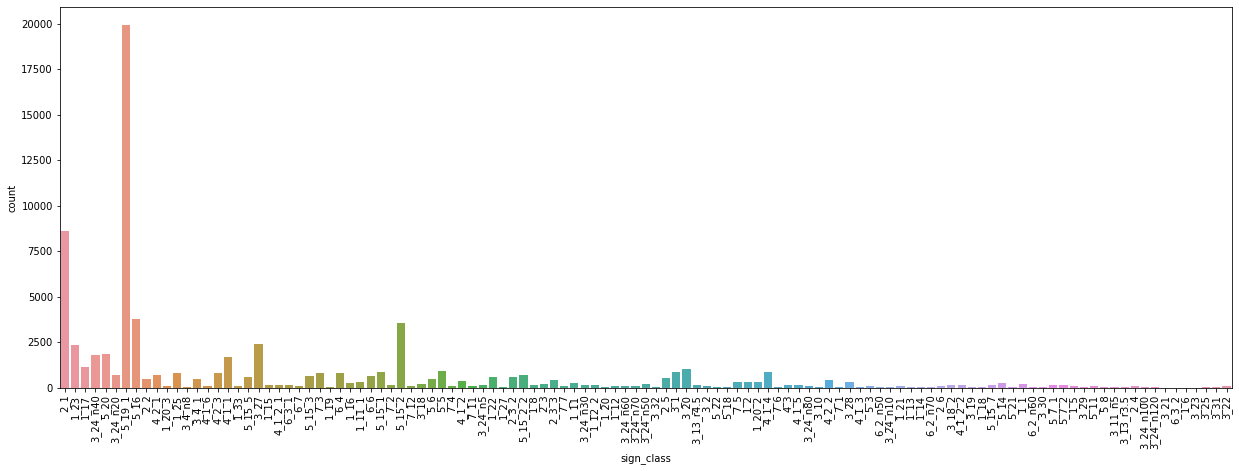

In [24]:
# print(gt_train)
print(gt_train['sign_class'].value_counts().to_json())
_, ax = plt.subplots(figsize=(21, 7))
plt.xticks(rotation=90)
sns.countplot(x='sign_class', data=gt_train, ax=ax);

In [26]:
EXTRACT_BIG = True
EXTRACT_SPECIFIC_CLASSES = True

if EXTRACT_SPECIFIC_CLASSES == False:
    CLASSES = gt_train['sign_class'].values
    print("[!] Assume classification for all of available classes")
    
else:
    CLASSES = [
        '1_1', '1_6', '1_8', '1_22', '1_31', '1_33', '2_1', '2_2', 
        # ~2_3_1
        '2_3', \
        # /~2_3_1
        '2_4', '2_5', '3_1', 
        # ~3_18_1
        '3_18', 
        # /~3_18_1
        '3_20', '3_21', '3_22', '3_23', \
        # all speed limits
        '3_24_n10', '3_24_n20', '3_24_n30', '3_24_n40', '3_24_n50', '3_24_n60', \
        '3_24_n70', '3_24_n80', '3_24_n90', '3_24_n100', '3_24_n110', '3_24_n120', '3_24_n130', \
        # /all speed limits
        '3_25', '3_27', '3_28', '3_31', '4_1_1', '4_3', '5_5', '5_6', '5_16', 
        '5_19_1',  
        #'5_19_2', \ ~ '5_19_1'
        '5_20', '6_3_2', '6_4', '7_3', '7_4'
    ]
    print("[+] Classification for all of those classes:\n", CLASSES)

def printProgressEnum(index, length, label=None):
    print('\r{}Progress: {}/{} ({:.2f}%)'.
                  format(label if label != None else '', index + 1, length, 100 * (index + 1) / length), flush=True, end='')

def getPictureSignClass(filename=None, path=None, index=None):
    if index:
        return gt_train.iloc[index]['sign_class']
    if path:
        return gt_train[gt_train['filename']==str(path).split(sep='\\')[-1]]['sign_class'].values[0]
    else:
        if filename:
            return gt_train[gt_train['filename']==filename]['sign_class'].values[0]
        else:
            assert False, 'wrong arg'

if EXTRACT_BIG == True:
    import imagesize
    
    list_of_origin_train_images = os.listdir(train_dir_source)
    
    path = pathlib.Path('train_big_images')
    path.mkdir(parents=True, exist_ok=True)
    included_clases = set()
    
    gt_train_size = len(gt_train.index)
    
    for index, row in gt_train.iterrows():

        full_path_to_image = train_dir_source / row['filename']
        
        # width, height = imagesize.get(full_path_to_image)
        # min_size = 50
        # if width > min_size and height > min_size:
        
        if True:
            if EXTRACT_SPECIFIC_CLASSES:
                class_for_current_image = row['sign_class']
                
                if class_for_current_image in CLASSES:
                    included_clases.add(class_for_current_image)
                    # shutil.copy2(full_path_to_image, train_dir)
                else:
                    gt_train.loc[index, 'IsPresent'] = 0
                    # print('\n[!]', class_for_current_image, 'is not CLASSES')
            else:
                shutil.copy2(train_dir_source / image_end_path, train_dir)
        
        if (index % 100 == 0) or (index + 1 == gt_train_size):
            printProgressEnum(index, gt_train_size)
    
    not_included_signs = set(CLASSES) - included_clases
    if not_included_signs:
        print('\n[!] These signs were not included: \n', not_included_signs)
        
list_of_big_train_images = os.listdir(train_dir)

[+] Classification for all of those classes:
 ['1_1', '1_6', '1_8', '1_22', '1_31', '1_33', '2_1', '2_2', '2_3', '2_4', '2_5', '3_1', '3_18', '3_20', '3_21', '3_22', '3_23', '3_24_n10', '3_24_n20', '3_24_n30', '3_24_n40', '3_24_n50', '3_24_n60', '3_24_n70', '3_24_n80', '3_24_n90', '3_24_n100', '3_24_n110', '3_24_n120', '3_24_n130', '3_25', '3_27', '3_28', '3_31', '4_1_1', '4_3', '5_5', '5_6', '5_16', '5_19_1', '5_20', '6_3_2', '6_4', '7_3', '7_4']
Progress: 71017/71017 (100.00%)
[!] These signs were not included: 
 {'1_31', '3_24_n130', '3_24_n110', '3_24_n90'}


In [6]:
print(gt_train.loc[gt_train['IsPresent'] == 1]['sign_class'].value_counts())
print(np.mean(gt_train.loc[gt_train['IsPresent'] == 1]['sign_class'].value_counts()))

5_19_1    19913
2_1        8620
5_16       3751
3_27       2409
5_20       1841
4_1_1      1673
3_20       1036
5_5         915
3_1         868
6_4         794
7_3         790
1_22        603
2_5         512
2_2         479
5_6         474
3_28        294
1_1         198
4_3         149
1_8         120
7_4         110
1_33         82
3_21          3
6_3_2         1
1_6           1
Name: sign_class, dtype: int64
1901.5


In [17]:
def getPictureSignClass(filename=None, path=None, index=None):
    if index:
        return gt_train.iloc[index]['sign_class']
    if path:
        return gt_train[gt_train['filename']==str(path).split(sep='\\')[-1]]['sign_class'].values[0]
    else:
        if filename:
            return gt_train[gt_train['filename']==filename]['sign_class'].values[0]
        else:
            assert False, 'wrong arg'
            
getPictureSignClass(index=3)

'2_1'

train\054378.png 5_19_1


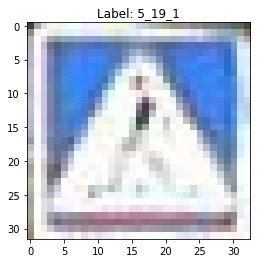

5_19_1


In [8]:
def getRandomPictureFromTrain():
    # instance = gt_train.sample(1)   # fix me or kill me
    while(1):
        instance = gt_train.sample(axis=0)
        # print(instance['IsPresent'].values)
        if instance['IsPresent'].values == 1:
            instance = instance['filename'].values[0]
            break
        
    # print('!', instance)
    path = pathlib.Path(train_dir / instance)
    # print(path)
    return path, getPictureSignClass(path=path)

def showPictureAndClass(path=None, gt_train_index=None):
    if path != None:
        pass
    else:
        if gt_train_index == None:
            assert False, 'cannot identify picture'
        else:
            path = train_dir / gt_train.iloc[gt_train_index]['filename']
    
    sign_class = str(getPictureSignClass(path=path))
    
    fig = plt.figure(figsize=(4, 4))
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.title(f'Label: {sign_class}')
    plt.show()
    
path, class_ = getRandomPictureFromTrain()
print(path, class_)
showPictureAndClass(path)
print(getPictureSignClass(path=path))

In [11]:
numbers_to_classes['sign_class'].to_list()

NameError: name 'numbers_to_classes' is not defined

In [12]:
included_clases

{'1_1',
 '1_22',
 '1_33',
 '1_6',
 '1_8',
 '2_1',
 '2_2',
 '2_5',
 '3_1',
 '3_20',
 '3_21',
 '3_27',
 '3_28',
 '4_1_1',
 '4_3',
 '5_16',
 '5_19_1',
 '5_20',
 '5_5',
 '5_6',
 '6_3_2',
 '6_4',
 '7_3',
 '7_4'}

In [15]:
np.unique(gt_train['sign_class'].values)

array(['1_1', '1_11', '1_11_1', '1_12', '1_12_2', '1_13', '1_14', '1_15',
       '1_16', '1_17', '1_18', '1_19', '1_2', '1_20', '1_20_2', '1_20_3',
       '1_21', '1_22', '1_23', '1_25', '1_27', '1_33', '1_5', '1_6',
       '1_8', '2_1', '2_2', '2_3', '2_3_2', '2_3_3', '2_5', '2_6', '3_1',
       '3_10', '3_11_n5', '3_13_r3.5', '3_13_r4.5', '3_18', '3_18_2',
       '3_19', '3_2', '3_20', '3_21', '3_24_n10', '3_24_n20', '3_24_n30',
       '3_24_n40', '3_24_n5', '3_24_n50', '3_24_n60', '3_24_n70',
       '3_24_n80', '3_27', '3_28', '3_29', '3_30', '3_32', '3_4_1',
       '3_4_n8', '4_1_1', '4_1_2', '4_1_2_1', '4_1_2_2', '4_1_3', '4_1_4',
       '4_1_5', '4_1_6', '4_2_1', '4_2_2', '4_2_3', '4_3', '5_11', '5_14',
       '5_15_1', '5_15_2', '5_15_2_2', '5_15_3', '5_15_5', '5_15_7',
       '5_16', '5_18', '5_19_1', '5_20', '5_21', '5_22', '5_3', '5_5',
       '5_6', '5_7_1', '5_7_2', '5_8', '6_2_n50', '6_2_n60', '6_2_n70',
       '6_3_1', '6_3_2', '6_4', '6_6', '6_7', '7_1', '7_11', '7_12',


In [ ]:
resnet18

In [ ]:
print(getPictureSignClass(path=train_dir / '005627.png'))

In [ ]:
included_clases_l = list(included_clases)
included_clases_l

In [ ]:
CLASSES_s = set(CLASSES)

In [ ]:
CLASSES_s - included_clases